In [1]:
# VesterAI - Notebook 03: Sentiment Analysis (News, Twitter, Reddit)

"""
Objective:
Use NLP models to assign sentiment labels (positive, negative, neutral) to financial text data.
We'll use:
1. FinBERT (fine-tuned on financial corpora)
2. VADER (rule-based baseline)
3. Optional: DistilBERT or RoBERTa for comparison

Output:
Cleaned datasets with sentiment scores → to be merged with stock data later.
"""

"\nObjective:\nUse NLP models to assign sentiment labels (positive, negative, neutral) to financial text data.\nWe'll use:\n1. FinBERT (fine-tuned on financial corpora)\n2. VADER (rule-based baseline)\n3. Optional: DistilBERT or RoBERTa for comparison\n\nOutput:\nCleaned datasets with sentiment scores → to be merged with stock data later.\n"

In [14]:
# Install transformers and sentiment libs
!pip install transformers --quiet
!pip install vaderSentiment --quiet
!pip install ipywidgets jupyterlab-widgets

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import os
import numpy as np

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installat

In [3]:
# Load data from /data/processed/
processed_path = "../data/processed"

tweet_df = pd.read_csv(os.path.join(processed_path, "AAPL_twitter_cleaned.csv"))
news_df = pd.read_csv(os.path.join(processed_path, "AAPL_news_cleaned.csv"))

reddit_path = os.path.join(processed_path, "AAPL_reddit_cleaned.csv")
reddit_df = pd.read_csv(reddit_path) if os.path.exists(reddit_path) else pd.DataFrame()

print(f"Tweets: {tweet_df.shape}")
print(f"News: {news_df.shape}")
print(f"Reddit: {reddit_df.shape if not reddit_df.empty else 'N/A'}")

Tweets: (95, 7)
News: (20, 5)
Reddit: (50, 8)


In [4]:
# Load FinBERT from Hugging Face
MODEL = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"FinBERT loaded on: {device}")

/home/tandel.r/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/home/tandel.r/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

/home/tandel.r/.local/lib/python3.8/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_lo

FinBERT loaded on: cuda


In [5]:
# Map class index to label
label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Function to run FinBERT on a single text
def get_finbert_sentiment(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        label = torch.argmax(probs).item()
        return label_map[label]
    except:
        return "neutral"

In [6]:
# Use tqdm for progress tracking
tqdm.pandas()

# Apply FinBERT sentiment
tweet_df["finbert_sentiment"] = tweet_df["clean_text"].progress_apply(get_finbert_sentiment)
news_df["finbert_sentiment"] = news_df["clean_headline"].progress_apply(get_finbert_sentiment)
if not reddit_df.empty:
    reddit_df["finbert_sentiment"] = reddit_df["clean_text"].progress_apply(get_finbert_sentiment)

print("Sentiment labels (FinBERT) added.")

100%|██████████| 50/50 [00:00<00:00, 99.20it/s] 

Sentiment labels (FinBERT) added.


In [7]:
# VADER: Rule-based sentiment analyzer
vader = SentimentIntensityAnalyzer()

def get_vader_label(text):
    score = vader.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

tweet_df["vader_sentiment"] = tweet_df["clean_text"].progress_apply(get_vader_label)
news_df["vader_sentiment"] = news_df["clean_headline"].progress_apply(get_vader_label)
if not reddit_df.empty:
    reddit_df["vader_sentiment"] = reddit_df["clean_text"].progress_apply(get_vader_label)

print("VADER baseline sentiment added.")

100%|██████████| 50/50 [00:00<00:00, 166.52it/s]

VADER baseline sentiment added.


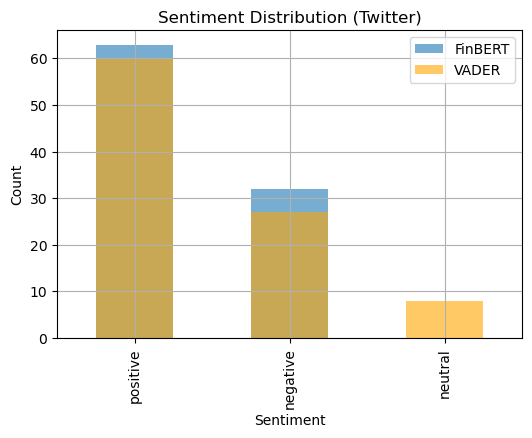

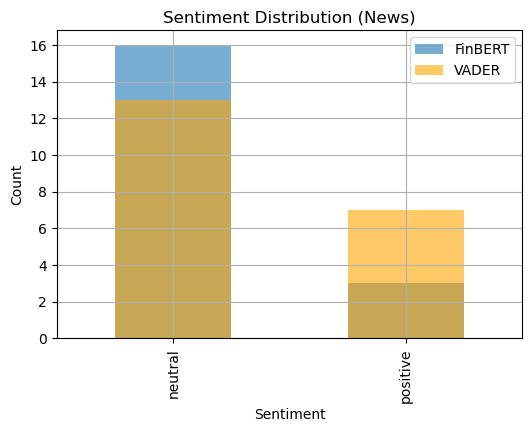

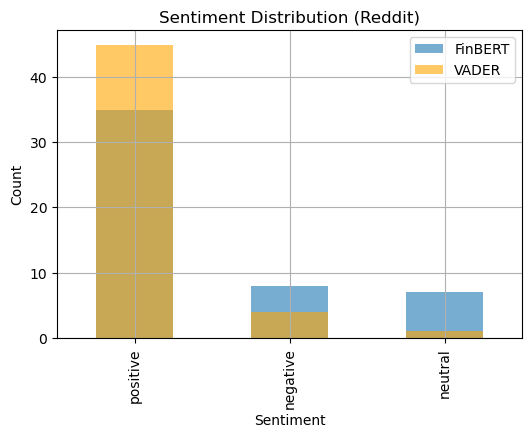

In [8]:
import matplotlib.pyplot as plt

def plot_sentiment_dist(df, source_name):
    plt.figure(figsize=(6, 4))
    df["finbert_sentiment"].value_counts().plot(kind="bar", alpha=0.6, label="FinBERT")
    df["vader_sentiment"].value_counts().plot(kind="bar", alpha=0.6, label="VADER", color="orange")
    plt.title(f"Sentiment Distribution ({source_name})")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sentiment_dist(tweet_df, "Twitter")
plot_sentiment_dist(news_df, "News")
if not reddit_df.empty:
    plot_sentiment_dist(reddit_df, "Reddit")

In [9]:
tweet_df.to_csv(os.path.join(processed_path, "AAPL_twitter_sentiment.csv"), index=False)
news_df.to_csv(os.path.join(processed_path, "AAPL_news_sentiment.csv"), index=False)
if not reddit_df.empty:
    reddit_df.to_csv(os.path.join(processed_path, "AAPL_reddit_sentiment.csv"), index=False)

print("Sentiment-labeled data saved to /data/processed/")

Sentiment-labeled data saved to /data/processed/


In [10]:
print("Sentiment Analysis Summary:")
print("Tweets →", tweet_df["finbert_sentiment"].value_counts().to_dict())
print("News →", news_df["finbert_sentiment"].value_counts().to_dict())
if not reddit_df.empty:
    print("Reddit →", reddit_df["finbert_sentiment"].value_counts().to_dict())

print("\nNext: Combine sentiment with stock data for feature engineering in Notebook 04.")

Sentiment Analysis Summary:
Tweets → {'negative': 63, 'neutral': 32}
News → {'negative': 16, 'neutral': 3, 'positive': 1}
Reddit → {'negative': 35, 'neutral': 8, 'positive': 7}

Next: Combine sentiment with stock data for feature engineering in Notebook 04.


In [11]:
# Install Hugging Face models and additional tokenizer support
!pip install transformers --quiet
!pip install sentencepiece --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)
roberta_model = roberta_model.to(device)

roberta_labels = {0: "negative", 1: "neutral", 2: "positive"}
print("RoBERTa model loaded.")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RoBERTa model loaded.


In [16]:
def get_roberta_sentiment(text):
    try:
        inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        outputs = roberta_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        label = torch.argmax(probs).item()
        return roberta_labels[label]
    except:
        return "neutral"

In [17]:
tweet_df["roberta_sentiment"] = tweet_df["clean_text"].progress_apply(get_roberta_sentiment)
news_df["roberta_sentiment"] = news_df["clean_headline"].progress_apply(get_roberta_sentiment)
if not reddit_df.empty:
    reddit_df["roberta_sentiment"] = reddit_df["clean_text"].progress_apply(get_roberta_sentiment)

print("RoBERTa sentiment labels added to all datasets.")

100%|██████████| 50/50 [00:00<00:00, 94.55it/s]

RoBERTa sentiment labels added to all datasets.


In [18]:
# Show sample sentiment comparisons
tweet_df[["clean_text", "finbert_sentiment", "vader_sentiment", "roberta_sentiment"]].sample(5)

,clean_text,finbert_sentiment,vader_sentiment,roberta_sentiment
72,get in on the next stockparty join with my lin...,negative,positive,positive
0,best stock traders group out there updates cha...,negative,positive,positive
24,rt over the long term its hard for a stock to ...,neutral,positive,negative
93,rt choose 1 which stock will outperform the ot...,neutral,neutral,neutral
23,rt over the long term its hard for a stock to ...,neutral,positive,negative


In [19]:
tweet_df.to_csv(os.path.join(processed_path, "AAPL_twitter_sentiment.csv"), index=False)
news_df.to_csv(os.path.join(processed_path, "AAPL_news_sentiment.csv"), index=False)
if not reddit_df.empty:
    reddit_df.to_csv(os.path.join(processed_path, "AAPL_reddit_sentiment.csv"), index=False)

print("All models' sentiment outputs saved.")

All models' sentiment outputs saved.


In [20]:
print("Sentiment Summary with 3 Models (FinBERT, VADER, RoBERTa):")
print("Tweets:", tweet_df["roberta_sentiment"].value_counts().to_dict())
print("News:", news_df["roberta_sentiment"].value_counts().to_dict())
if not reddit_df.empty:
    print("Reddit:", reddit_df["roberta_sentiment"].value_counts().to_dict())

Sentiment Summary with 3 Models (FinBERT, VADER, RoBERTa):
Tweets: {'neutral': 44, 'negative': 27, 'positive': 24}
News: {'neutral': 16, 'positive': 2, 'negative': 2}
Reddit: {'neutral': 43, 'positive': 4, 'negative': 3}
